# GD with adaptive step-size

Let 

$$\large F(\mathbf{u}) = 0.5|| \mbox{Op}(\mathbf{u}) - \mathbf{b} ||_2^2$$ 

represent a quadratic cost functional, where `Op`, in particular, is given by

* $ \mbox{Op}(\mathbf{u}) = A \mathbf{u} \qquad $ (matrix times vector)




## Import F2O

In [1]:

import F2O.F2O_utils as F2O
from F2O.fwOp.fwOperator import fwOp
from F2O.F2O_sptl import gd

import demo.synthData as sd

# Other imports
import matplotlib.pylab as PLT


## Synthetic data for $ \mbox{Op}(\mathbf{u}) = A \mathbf{u}$

Generate data involving a square random matrix and a random vector

$ \small \qquad \begin{array}{rcl}
 B & = & \mbox{randn}(N,N) \\
 A & = & B^TB + \alpha\cdot\mbox{diag}(N) \\
 A[:,k] & /= & \| A[:,k] \|_2 \;\; \forall k \qquad \mbox{ (normalization step)}
 & \\
 \mathbf{u}^* & = & \mbox{randn}(N,1) \\
 & \\
 b & = & A\mathbf{u}^* + \sigma\cdot \mbox{randn}(N,1) 
\end{array}$

In [2]:
N = 2000

synthData = sd.synthData()

A, b, xori = synthData.genDataMV(N, alpha=0.1*N)


### Step by step setup

GD's step-size can be automatically determine. 
* Cauchy step-size
* Barzilai-Borwein
* etc.




1. Set the arguments that define the optimization problem 

In [3]:
args = F2O.argsF2O()                           # NOTE: use args = F2O.argsF2O(enableJAX=False)
                                               #       to disbale JAX support

args.verbose    = True
args.fCostClass = args.f2oDef.cost_L2_lin      # F(x) = 0.5|| Op(x) - b ||_2^2, where Op(.) is lineal
args.freqSol    = False                         

2. Select the forward operator 

In [4]:
Op       = fwOp()
Op.linOp = args.f2oDef.fAx_matrixvec    # matrix times vector
Op.A     = A
  

3. Call the routine to solve the problem

In [7]:
ssCte = [5e-2, 5e-3, 5e-4]

ssPolicy = [args.f2oDef.ss_Cte, 
            args.f2oDef.ss_BBv2,
            args.f2oDef.ss_Cauchy]

nIter = 100

x = []
gdStats = []

args.verbose   = False

for k in range(len(ssPolicy)):
    
    args.ssPoliciy = ssPolicy[k]
    
    if args.ssPoliciy == args.f2oDef.ss_Cte:
       args.ssCte     = ssCte[k]                 # see GD_ex1.ipynb
    else:
       args.ssCte     = 0.0
    
    sol   = gd(Op, b, nIter, args)
    x.append(sol[0])
    gdStats.append(sol[1])

Plot results: cost functional evolution

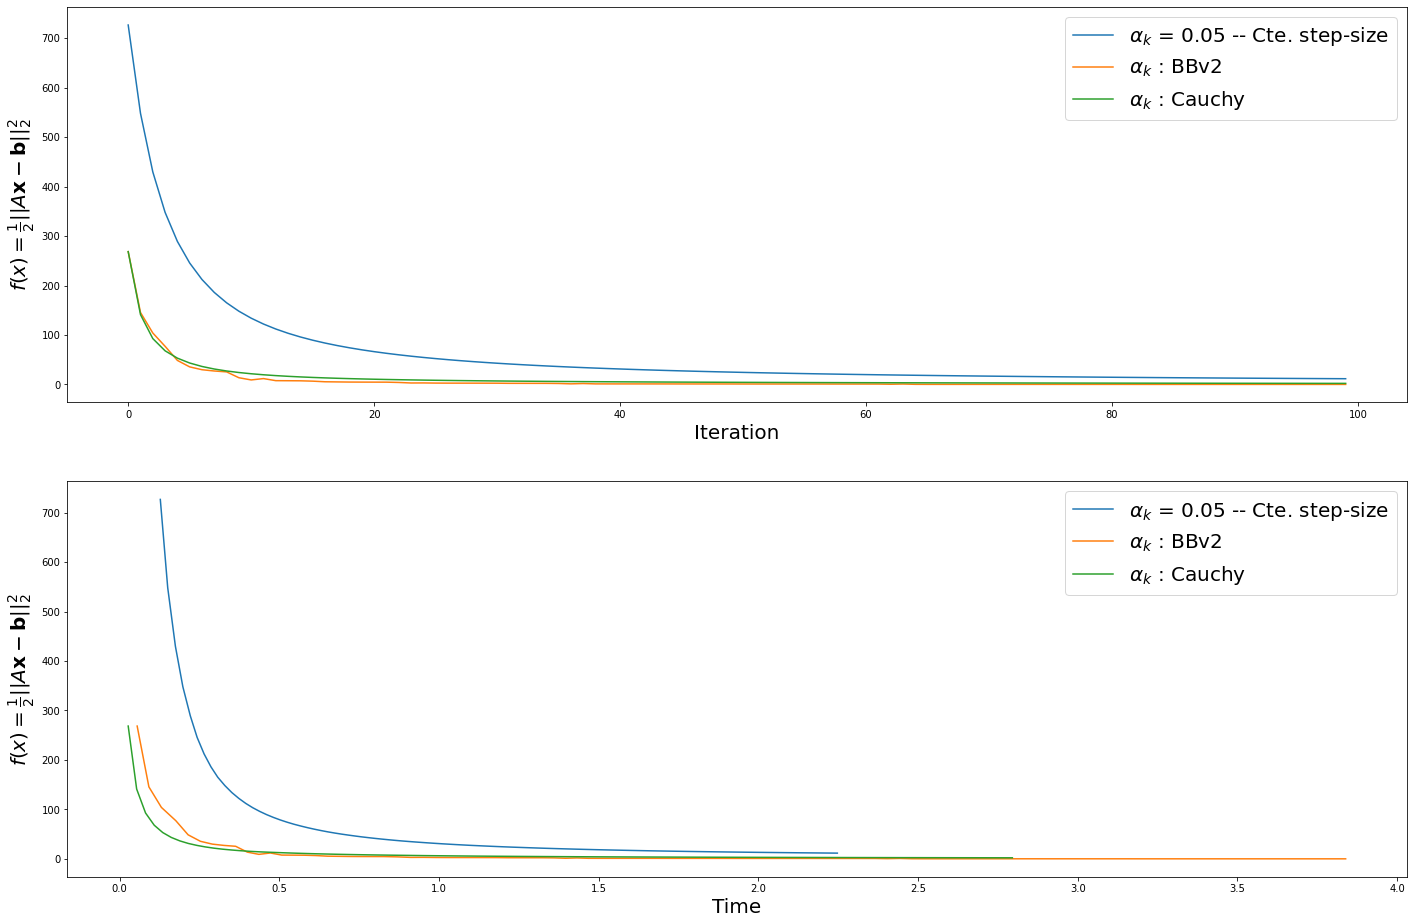

In [9]:

fig = PLT.figure(figsize=(24, 16))

ax1 = fig.add_subplot(2, 1, 1)

for k in range(len(ssPolicy)):
    if ssPolicy[k] == args.f2oDef.ss_Cte:
       PLT.plot(gdStats[k][:,0], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte[k], args.f2oDef.ss_list[ssPolicy[k]]) )
    else:
       PLT.plot(gdStats[k][:,0], label=r'$\alpha_k$ : {0}'.format(args.f2oDef.ss_list[ssPolicy[k]]) )
     
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2} \|\| $Op$(\mathbf{u}) - \mathbf{b} \|\|_2^2$',fontsize=20)
PLT.xlabel('Iteration',fontsize=20)

ax2 = fig.add_subplot(2, 1, 2)

for k in range(len(ssPolicy)):
    if ssPolicy[k] == args.f2oDef.ss_Cte:
       PLT.plot(gdStats[k][:,2], gdStats[k][:,0], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte[k], args.f2oDef.ss_list[ssPolicy[k]]) )
    else:
       PLT.plot(gdStats[k][:,2], gdStats[k][:,0], label=r'$\alpha_k$ : {0}'.format(args.f2oDef.ss_list[ssPolicy[k]]) )
     
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2} \|\| $Op$(\mathbf{u})  - \mathbf{b} \|\|_2^2$',fontsize=20)
PLT.xlabel('Time',fontsize=20);


### NOTE

* Adaptive faster iteration
* Constant faster time-performance

